In [86]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

from pathlib import Path
from utide import solve

# latitude of tide gauge (needed for tidal analysis)
lat = 56.550

## 1. Load Data

1) Hourly sea level data for Nain (UH#833) downloaded from [UHSLC](http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv). 1963-2018

2) Hourly sea level data for Nain (Station 1430) downloaded from [DFO](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=1430&user=isdm-gdsi&region=ATL) 2018-2022         

In [49]:
# URL to dataset on UHSLC website
url = "http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv"

# read data into `pandas.DataFrame`
df1 = pd.read_csv(
    url,                                              # URL to dataset on UHSLC website
    header=None,                                      # the dataset doesn't have a header
    names=["year", "month", "day", "hour", "height"], # name columns
    na_values=-32767                                  # set invalid values to NaN
)

# convert columns with date/time information to datetime object
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df1["time"] = pd.to_datetime(df1[["year", "month", "day", "hour"]])

# use the datetime object as index (this will make things much easier)
df1 = df1.set_index("time")

# remove the columns with date/time information
# (all the information is now contained in the index)
df1 = df1.drop(["year", "month", "day", "hour"], axis=1)

# remove all NaN values - UTide auto detects irregularly spaced times
df1 = df1.dropna() 

# add a column to identify the data source
df1["source"] = 'UHSLC'

# convert "height" from [mm] to [m]
df1["height"] = df1["height"]/1000

In [50]:
# display the end of the data
df1.tail()

,height,source
time,,
2018-12-31 19:00:00,1.889,UHSLC
2018-12-31 20:00:00,1.821,UHSLC
2018-12-31 21:00:00,1.633,UHSLC
2018-12-31 22:00:00,1.339,UHSLC
2018-12-31 23:00:00,1.023,UHSLC


In [51]:
# DFO data is in a .csv file on local machine
# read data into `pandas.DataFrame`
df2 = pd.read_csv(
    'DFO1430_2019to2022.csv',                   # Data downloaded from DFO 1430
    header=7,                                   # Seven line header
    parse_dates=[['Obs_date', 'Obs_time']],     # Identify date & time columns
)

# convert columns with date/time information to datetime object
df2["time"] = pd.to_datetime(df2["Obs_date_Obs_time"])

# remove the columns with date/time information
df2 = df2.drop(["Obs_date_Obs_time"], axis=1)

# use the datetime object as index
df2 = df2.set_index("time")

# rename sea level column to match df1
df2.rename(columns={'SLEV(metres)':'height'}, inplace=True)

# add a column to identify the data source
df2["source"] = 'DFO'

# display the start of the data
df2.head()

,height,source
time,,
2019-01-01 00:00:00,0.77,DFO
2019-01-01 01:00:00,0.67,DFO
2019-01-01 02:00:00,0.73,DFO
2019-01-01 03:00:00,0.94,DFO
2019-01-01 04:00:00,1.24,DFO


In [52]:
frames = ([df1, df2])
df = pd.concat(frames)
df

,height,source
time,,
1963-10-17 05:00:00,0.53,UHSLC
1963-10-17 06:00:00,0.65,UHSLC
1963-10-17 07:00:00,0.97,UHSLC
1963-10-17 08:00:00,1.38,UHSLC
1963-10-17 09:00:00,1.87,UHSLC
...,...,...
2021-12-31 00:00:00,0.99,DFO
2021-12-31 01:00:00,0.71,DFO
2021-12-31 02:00:00,0.59,DFO


### Figure: Raw Time Series

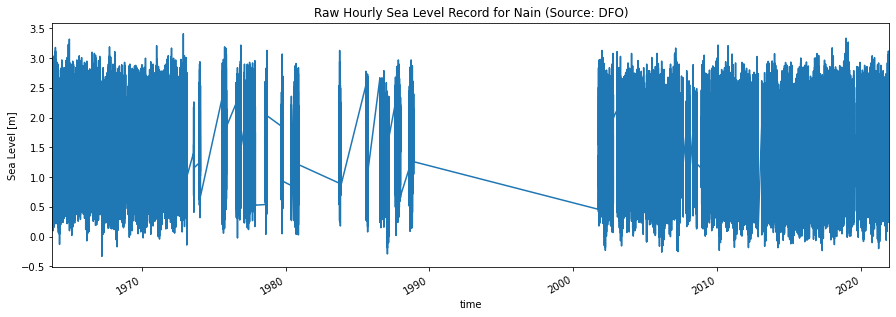

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["height"].plot(
    ax=ax,
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

plt.show()

## 2. Tidal Analysis

From [UTide GitHub page](https://github.com/wesleybowman/UTide):

```
coef = solve(time, time_series_u, time_series_v,
             lat=30,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)
```

Based on previous analysis, we are adjusting the Rayleight minimum to 1.2

In [44]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide. Wrapper from Christoph Renkl.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=1.2,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [46]:
result = df["height"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()
ds

<xarray.Dataset>
Dimensions:      (constituent: 17, time: 390)
Coordinates:
  * time         (time) datetime64[ns] 1963-10-31 1963-11-30 ... 2021-12-31
  * constituent  (constituent) object '2MK5' '2MS6' '2SK5' ... 'S2' 'S4' 'SK3'
Data variables:
    A            (time, constituent) float64 0.001506 nan ... 0.001576 0.004225
    A_ci         (time, constituent) float64 0.003478 nan ... 0.00231 0.002561
    g            (time, constituent) float64 352.3 nan 190.4 ... 211.4 187.9
    g_ci         (time, constituent) float64 132.3 nan 42.47 ... 83.98 34.78

### Figure: M2 Tidal Amplitude 1963-2022

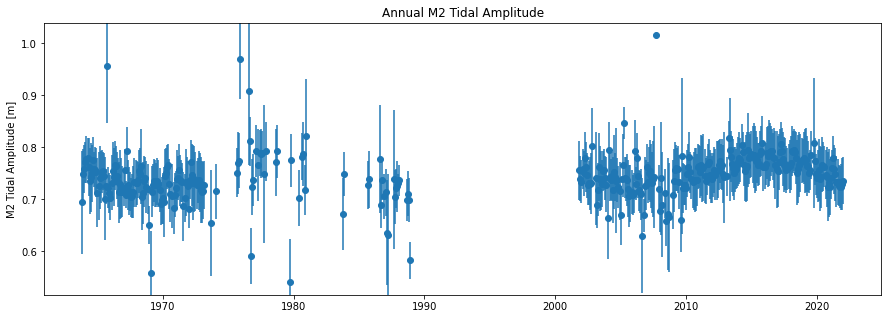

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

plt.show()
#plt.savefig('nain_tides.png', facecolor='w')

## 1. De-tide the Raw Data

The value 'mean' in 'coef' represents the height with the tidal range for all resolved consitituents subtracted

In [67]:
# make a time variable in floating point days
time = mdates.date2num(df["height"].index.to_pydatetime())

# use UTide to run tidal analysis
coef = solve(
    time, df["height"].values,   # input variables: time and sea level as numpy arrays
    lat=lat,       # latitude of tide gauge
    nodal=False,       
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=1.2,
    verbose=False       # no messages
)

# coef

Reindexing the raw data for display purposes

In [83]:
# create a new index from the date range specified
# use hourly frequency to match the hourly gage data

index = pd.date_range('1963-10-17 ', '2021-12-31', freq='H')

# reassign new index to df
dv=df.reindex(index=index)

### Figure: Sea level, tides, and non-tidal components

AttributeError: 'Line2D' object has no property 'fmt'

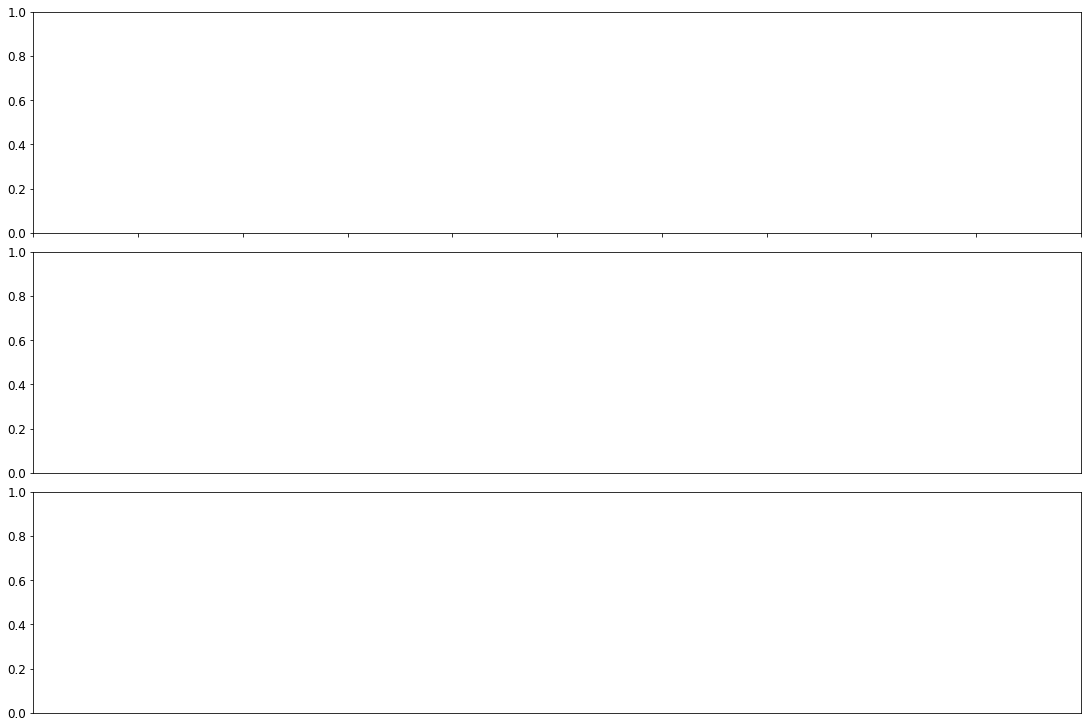

In [104]:
# Set parameters for subplots
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["ytick.labelsize"] = 12
rcParams["xtick.labelsize"] = 12

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(15, 10), 
                      sharex=True, constrained_layout = True)

# plot the non-tidal component
ax[0].plot(df["height"].groupby(pd.Grouper(freq="Y")).mean(), 
           color='tab:grey', fmt='o')

# title and axis label
ax[0].set(
    title=f"Non-tidal component",
    ylabel=f"{constituent} Sea level [m]"
)

# -------------

# plot the M2 tidal component

constituent = "M2"

ax[1].errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o",
    color='tab:olive'
)

# title and axis label
ax[1].set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"Sea Level [m]",
)

# -------------

# plot the raw data
ax[2].plot(dv["height"],
          color='tab:cyan')

# title and axis label
ax[2].set(
    title=f"Raw Gage Height Data",
    ylabel=f"Sea Level [m]",
    xlabel=f"Year"
)

plt.show()